### Import dei pacchetti

In [ ]:
gdrive = True

In [ ]:
import sys
import os
if gdrive:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %tensorflow_version 1.x
    sys.path.append('/content/gdrive/My Drive/Tesi/src/')
    ROOT_DIR = "/content/gdrive/My Drive/Tesi/"
    data_path = "/content/gdrive/My Drive/Tesi/processedData/speaker1/train&validation/"
    !pip install deepspeech
    !apt-get install sox libsox-dev libsox-fmt-all
else:
    ROOT_DIR = os.path.dirname(os.path.abspath('.'))
    data_path = ROOT_DIR + "\\processedData\\speaker1\\train&validation\\"

Mounted at /content/gdrive
TensorFlow 1.x selected.
     |████████████████████████████████| 9.2MB 10.8MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-ao
  libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3
Suggested packages:
  libaudio2 file
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-dev libsox-fmt-all
  libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss
  libsox-fmt-pulse libsox3 sox
0 upgraded, 18 newly installed, 0 to remove and 17 not upgraded.
Need to get 1,267 kB of archives.
After this operation, 9,153 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from training_ops import *
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy
from dataset import DataSet
import pandas as pd
import librosa
from evaluation_ops import *
from params import *
import soundfile as sf
from tqdm.notebook import tqdm

### Import del modello

In [ ]:
multispeaker = False
data_path = read_datapath(multispeaker = multispeaker, gdrive = gdrive)
architecture_params, opt_params = read_params('gionet')
#dir_name = 'gionet.lr0.000030dec.4.g3.b128'
#architecture_params, opt_params = read_params_from_logdir(os.path.join(data_path, 'model_ckpt/{}'.format(dir_name))) #gionet.lr0.000030dec.4.g4.b128

In [ ]:
if multispeaker:
    read_best_model = True
else:
    read_best_model = False

In [ ]:
logdir = get_logdir(data_path, opt_params, architecture_params)
checkpoint_root = os.path.join(logdir, 'model.ckpt')
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True, log_device_placement=True))
if os.path.isdir(logdir):
    print('Model loading...')
    if read_best_model:
        checkpoint = os.path.join(logdir, 'best_model')
    else: 
        checkpoint = read_latest_checkpoint(logdir, gdrive)
    meta = checkpoint + '.meta'
    saver = tf.train.import_meta_graph(meta)
    g = tf.get_default_graph()
    saver.restore(sess, checkpoint)
    X_lr, Y, alpha = tf.get_collection('inputs')[0:3]
    inputs = (X_lr, Y, alpha)
    predictions = tf.get_collection('preds')[0]
    with open(os.path.join(logdir, 'train_metrics.pickle'), 'rb') as handle:
        train_metrics = pickle.load(handle)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0

Model loading...
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Tesi/processedData/speaker1/train&validation/model_ckpt/gionet.lr0.000030dec.4.g3.b128/model_ckpt-174


### Applicazione del modello su un singolo file audio con lunghezza arbitraria

In [ ]:
audio_raw_data_path = os.path.join(ROOT_DIR, 'rawData', 'VCTK-Corpus', 'wav48')

In [ ]:
speacker_id = 'p225' #min is 225 (speacker 1), max is 376
audio_id = '365'
audio_file = os.path.join(audio_raw_data_path, speacker_id, speacker_id + '_' + audio_id + '.wav')
fs = 16000
sig, rate = librosa.load(audio_file, sr=fs, mono=False)

In [ ]:
f1 = ModelOnSingleFile(sig, rate, architecture_params['r'], sess, inputs, predictions, interp = True)

In [ ]:
path_deepspeech_model = os.path.join(ROOT_DIR, 'processedData', 'speech_to_text_models')
model = get_deepspeech_model(path_deepspeech_model)
assert fs == model.sampleRate()

In [ ]:
get_txt(audio_file, model, fs, gdrive)

'he did not see it'

In [ ]:
#REAL
ipd.Audio(f1.original_version(), rate = fs)

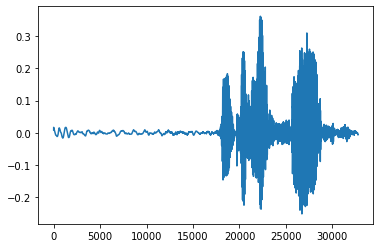

In [ ]:
plt.plot(f1.original_version()); plt.show()

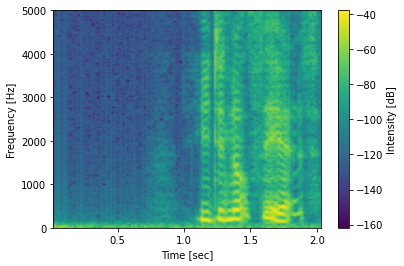

In [ ]:
plot_stft_spectogram(f1.original_version(), limit_frequency_to_plot= 5000)

In [ ]:
#LOW-RES
ipd.Audio(f1.low_res(), rate = fs)

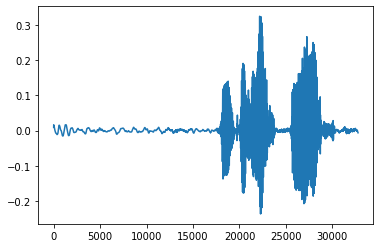

In [ ]:
plt.plot(f1.low_res()); plt.show()

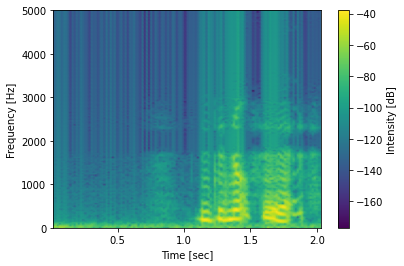

In [ ]:
plot_stft_spectogram(f1.low_res(), limit_frequency_to_plot= 5000)

In [ ]:
#MODEL VERSION
ipd.Audio(f1.get_model_hr(), rate = fs)

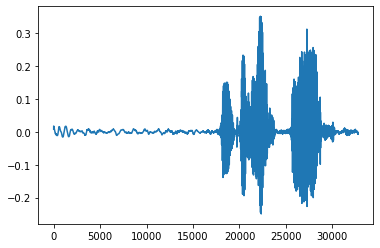

In [ ]:
plt.plot(f1.get_model_hr()); plt.show()

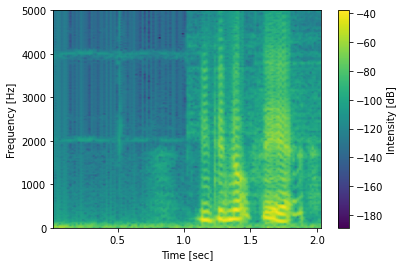

In [ ]:
plot_stft_spectogram(f1.get_model_hr(), limit_frequency_to_plot= 5000)

In [ ]:
# ### Save audio files
# examples_dir = os.path.join(ROOT_DIR, 'processedData', 'speaker1', 'examples')
# scipy.io.wavfile.write(os.path.join(examples_dir,'{}_original.wav'.format(audio_id)), rate, np.array(f1.original_version(), dtype = np.float32))
# scipy.io.wavfile.write(os.path.join(examples_dir,'{}_low_quality.wav'.format(audio_id)), rate, np.array(f1.low_res(), dtype = np.float32))
# scipy.io.wavfile.write(os.path.join(examples_dir,'{}_{}.wav'.format(audio_id, dir_name)), rate, np.array(f1.get_model_hr(), dtype = np.float32))